Advanced Statistics for Physics Analysis 2022/23

Antonio Feltrin, Student ID 2097126

antonio.feltrin@studenti.unipd.it

# Lab 5: Monte Carlo (I)

Inference, Monte Carlo Markov Chain

In [1]:
library (tibble)
library(scales)
library(ggplot2)
library(rjags)
library(coda)

Loading required package: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



In [2]:
#Some functions for plotting
myplot <- function(x1,y1,winw=8,winh=6,title='Prior',xlab='p',ylab='pdf',mycol='orange',ltype =1, lwdt=1,type='l', fillit=TRUE,xrange=c(min(x1),max(x1))){
       options(repr.plot.width=winw, repr.plot.height=winh)
       plot(x1,y1,
       col = mycol,
       main = title,
       xlab = xlab,
       type = type,
       xlim = xrange,
       lty = ltype,
       lwd = lwdt,
       ylab = ylab,
       )
       grid()
       if(fillit){
              polygon(x = c(min(x1),x1,max(x1)),
              y = c(0,y1,0),
              col=alpha('#9daed1',0.4))
              }
}

mylines <- function(x1,y1,title='Posterior',xlab='p', ylab='pdf',mycol='orange',lwdt=1,ltype=1){
       lines(x1,y1,
       col = mycol,
       lwd=lwdt,
       lty = ltype,
       xlab = xlab,
       ylab = ylab
       )
}

mypoly <- function(pdf,qleft=min(x1),qright=max(x1),mycol='#9daed1',N1=501){    
       x1.95 <- seq(qleft, qright, by=1/N1)
       y1.95 <- c(0,pdf(x1.95),0)
       polygon(x = c(qleft,x1.95,qright),
       y = y1.95,
       col=alpha(mycol,0.3))
}

mytext <- function(posx,posy=5,ltype=2,lwdt=1,mycol='black',epsilon=0,vert=TRUE){ #annotate quantiles
    for(xi in posx){
       if (vert == TRUE)  {
              abline(v=xi,lty=ltype,lwd=lwdt,col=mycol)
              text(x=xi-epsilon,y=posy,srt=90,label=round(xi,3))
       }
       else {
              abline(h=posy,lty=ltype,lwd=lwdt,col=mycol)
              text(x=xi-epsilon,y=posy,label=round(posy,3))  
       }
    }
}

### Exercise 1
Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the Poisson distribution can be very useful in applied statistics when describing low-frequency events in a large population. In a famous example he showed that the number of deaths by horse kick among the Prussian army follows the Poisson distribution.

Considering the following to sets of observations taken over a fixed large time interval in two different corps:

In [3]:
y <- c(0,1,2,3,4,5)
n1 <- c(109,65,22,3,1,0)
n2 <- c(144,91,32,11,2,0)

LBJdata <- tibble(y,n1,n2)
LBJdata

y,n1,n2
<dbl>,<dbl>,<dbl>
0,109,144
1,65,91
2,22,32
3,3,11
4,1,2
5,0,0


In [4]:
unroll <- function(freq, counts){
    measures <- c()
    for (i in 1:length(y)){measures<-c(measures,rep(freq[i],counts[i]))}
    return(measures)
}

series1 <- unroll(y,n1)
series2 <- unroll(y,n2)

#### 1.a 
Assuming a uniform prior, compute and plot the posterior distribution for $\gamma$, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the $95\%$ credibility interval.

As always, uniform prior, poissonian likelihood give gamma posterior.

In [5]:
inferePoi <- function(series1,overlay=FALSE,atitle,ap,ucol='forestgreen') {
     #Uniform Prior (already normalized)
    options(repr.plot.width=12, repr.plot.height=8)

    N1 <- 501
    counts1 <- length(series1)
    p1 <- seq(0,counts1,by=1)
    mu1 <- seq(0,1,length.out=N1)

    prior <- dunif(p1,0,counts1) # rep(1,counts1+1) #

    alpha.post <- sum(series1) + ap #depends on prior
    lambda.post <- length(series1)

    post <- function(mu) {dgamma(mu,shape=alpha.post,rate=lambda.post)}

    mean <- alpha.post/lambda.post
    variance <- alpha.post/(lambda.post^2)
    median <- qgamma(0.5,alpha.post,lambda.post)


    cat('\n',atitle,'\n')
    cat('I found a posterior with alpha =',alpha.post,'and lambda =',lambda.post,'\n')
    cat('I found a posterior with mean =',mean,'variance =',variance,'and median =',median,'\n')

    #plots
    q = 0.025
    left = qgamma(q,alpha.post,lambda.post)
    right = qgamma(1-q,alpha.post,lambda.post)
    cat('left bound =',left,'right bound =',right,'\n')

    if (overlay==FALSE){
        myplot(mu1,post(mu1),fillit = FALSE,title = 'Posterior',mycol=ucol,xrange=c(0,1),xlab = 'mu')
    } else{
        mylines(mu1,post(mu1),mycol=ucol,xlab = expression(mu))
    }
    mypoly(post,left,right,mycol=ucol)
    mytext(c(left,right),posy=1.3,mycol=ucol)
    mytext(mean,posy=3.3,mycol=ucol)
    
    return(post)
}


 Uniform series2 
I found a posterior with alpha = 197 and lambda = 280 
I found a posterior with mean = 0.7035714 variance = 0.002512755 and median = 0.7023813 
left bound = 0.6087487 right bound = 0.805157 

 Uniform series1 
I found a posterior with alpha = 123 and lambda = 200 
I found a posterior with mean = 0.615 variance = 0.003075 and median = 0.6133341 
left bound = 0.5111251 right bound = 0.7283408 


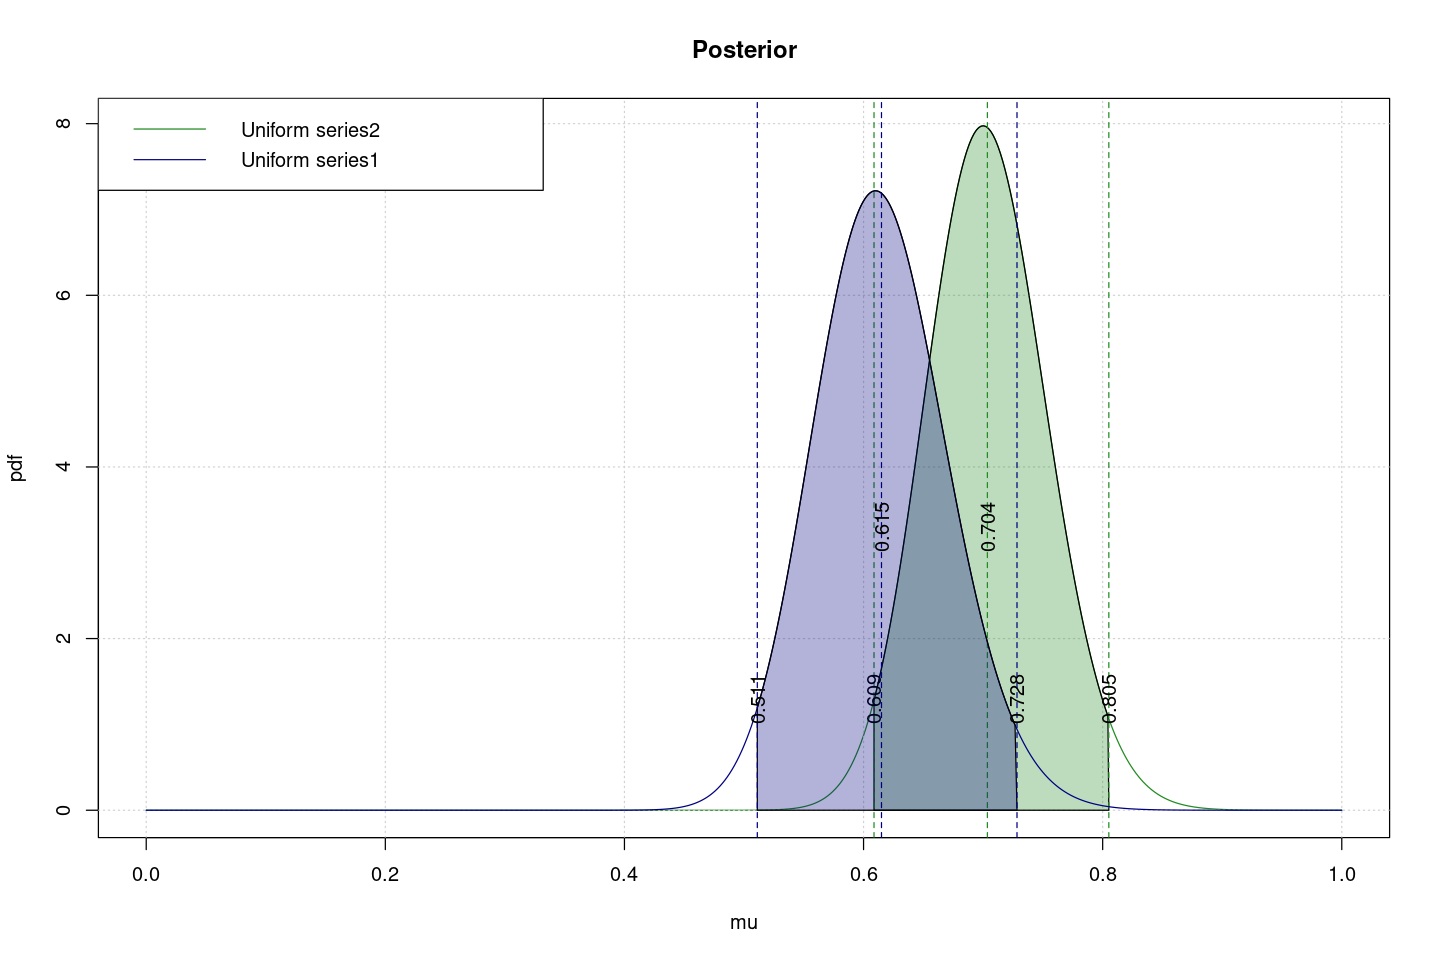

In [6]:
titles = c('Uniform series2','Uniform series1')
cols = c('forestgreen','navy')
postu1 <- inferePoi(series2,atitle=titles[1],ap=1)
postu2 <- inferePoi(series1,overlay=TRUE,atitle=titles[2],ap=1,ucol=cols[2])
legend('topleft', titles, col=cols, lty=1, bty ='o')

#### 1b Assuming now a Jeffreys’ prior,
$g(\lambda) \propto 1/\sqrt{\lambda}$ , with $\lambda > 0$
compute and plot the posterior distribution for $\lambda$, the death rate over the measurement time.
Determine the posterior mean, median and variance, and compute the $95\%$ credibility interval.


 Jeffrey's series2 
I found a posterior with alpha = 196.5 and lambda = 280 
I found a posterior with mean = 0.7017857 variance = 0.002506378 and median = 0.7005956 
left bound = 0.6070878 right bound = 0.8032465 

 Jeffrey's series1 
I found a posterior with alpha = 122.5 and lambda = 200 
I found a posterior with mean = 0.6125 variance = 0.0030625 and median = 0.6108341 
left bound = 0.5088464 right bound = 0.7256196 


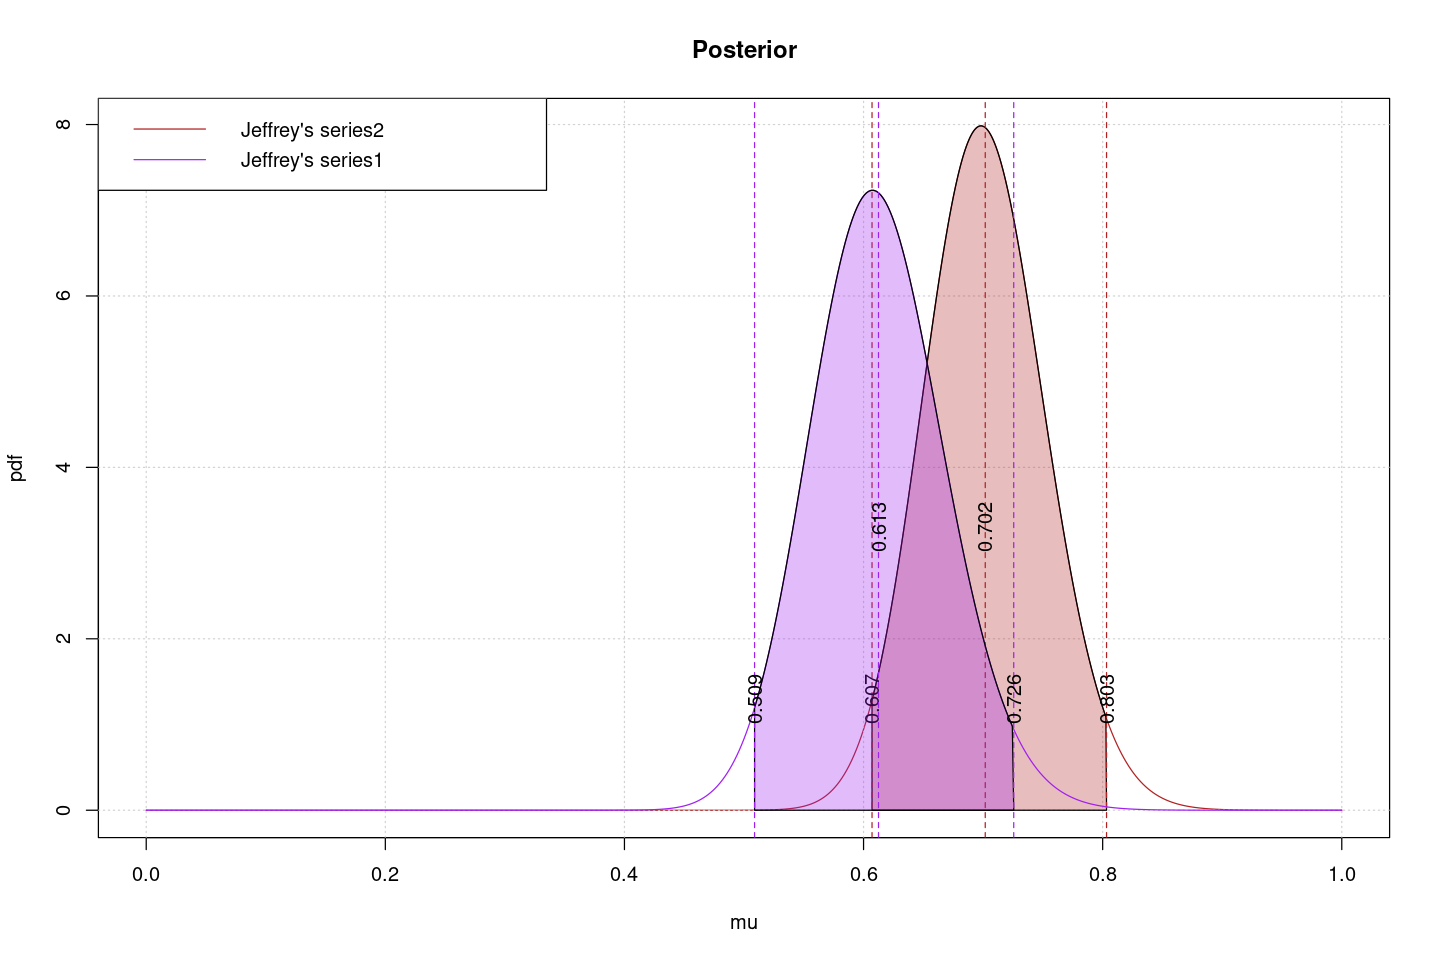

In [7]:
titles = c('Jeffrey\'s series2','Jeffrey\'s series1')
cols = c('firebrick','purple')
postj1 <- inferePoi(series2,atitle=titles[1],ap=1/2,ucol=cols[1])
postj2 <- inferePoi(series1,overlay=TRUE,atitle=titles[2],ap=1/2,ucol=cols[2])
legend('topleft', titles, col=cols, lty=1, bty ='o')

# Exercise 2
solve Exercise 1 with a Markov Chain Monte Carlo. Build your own MCMC, using the functions
introduced during lectures, or using a MCM library like JAGS.

For this section and exercise 4 I will adapt the code given in the slides ``Gibbs sampling and JAGS`` of the course.

In [8]:
# Parameters :
# func : a function whose first argument is a real vector of parameters
# theta.init : the initial value of the Markov Chain (and of func)
# n.sample: number of required samples
# sigma : standard deviation of the gaussian MCMC sampling pdf
mc_nsample <- 10^4
mc_sigma <- 0.3

metropolis.1dim <- function (func , theta.init=0.5 , n.sample=mc_nsample , sigma=mc_sigma) {
    theta.cur <- theta.init
    func.Cur <- log10(func(theta.cur))
    func.Samp <- matrix(data=NA , nrow=n.sample , ncol=2+1) 
    n.accept <- 0
    rate.accept <- 0.0
    
    for (n in 1:n.sample) {
        theta.prop <- rnorm(n=1, mean = theta.cur , sigma)
        func.Prop <- log10(func(theta.prop))
        logMR <- func.Prop - func.Cur # Log10 of the Metropolis ratio
        func.Samp[n, 3] <- 0
        if ( logMR >=0 || logMR >log10(runif(1)) ) { #logMR>0 : prop/cur > 1; else accept anyway but if > rng thresh
            theta.cur <- theta.prop
            func.Cur <- func.Prop
            n.accept <- n.accept + 1
            func.Samp[n, 3] <- 1
        }
        func.Samp[n, 1] <- func.Cur
        func.Samp[n, 2] <- theta.cur
    }
    return(func.Samp)
}

In [9]:
### Running parameters
set.seed(2097126)

chain <- metropolis.1dim(func= postu1)

In [10]:
chain2 <- as_tibble(chain)
chain2 <- tibble(logF=chain[,1],param=chain[,2],change=chain[,3])
head(chain2)
cat('MH makes ',sum(chain2$change),'jumps over ',mc_nsample,'steps')

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”


logF,param,change
<dbl>,<dbl>,<dbl>
-2.426874,0.5220466,1
-2.426874,0.5220466,0
-2.426874,0.5220466,0
-2.426874,0.5220466,0
-2.426874,0.5220466,0
-2.426874,0.5220466,0


MH makes  2026 jumps over  10000 steps

For the jumps in the MH algorithm, I chose a sigma of $0.3$, which should be large enoough to explore all the possible values of $p \in [0,1]$.

In [11]:
th_vs_MC <- function(post,chain,name) {
    x <- seq(0, 1, length.out=501)
    y <- post(x)
    plot(x, y, yaxs="i", ylim=c(0, 1.2*max(y)),
        type="n", xlab= expression(mu), 
        main=name,
        ylab= expression (paste('f(',mu ,')', sep='')))
    sa <- which(chain[,2]>=min(x) & chain[,2]<=max(x))

    hist <- hist(chain[sa ,2], breaks =seq(from=min(x), to=max(x),
    length.out=100), plot=FALSE)
    Zhist <- sum(hist$counts ) * min(diff(hist$breaks)) # integrate histo: sum {f(x) Delta_x}

    lines(hist$breaks , c(hist$counts/Zhist ,0), #plot normalized histogram onto theoretical posterior
    col='navy', type="s", lwd=2, lty=5)

    lines(x, y, col='firebrick 3', lwd=1, lty=1)

    leg.labels = c('analytical', 'MCMC')
    leg.ltype = c(1, 5)
    leg.colors = c('firebrick 3','navy')
    legend("topleft", inset =.05, bty='n', legend = leg.labels, 
           lty=leg.ltype , col=leg.colors , lwd = 2)
    grid()
}

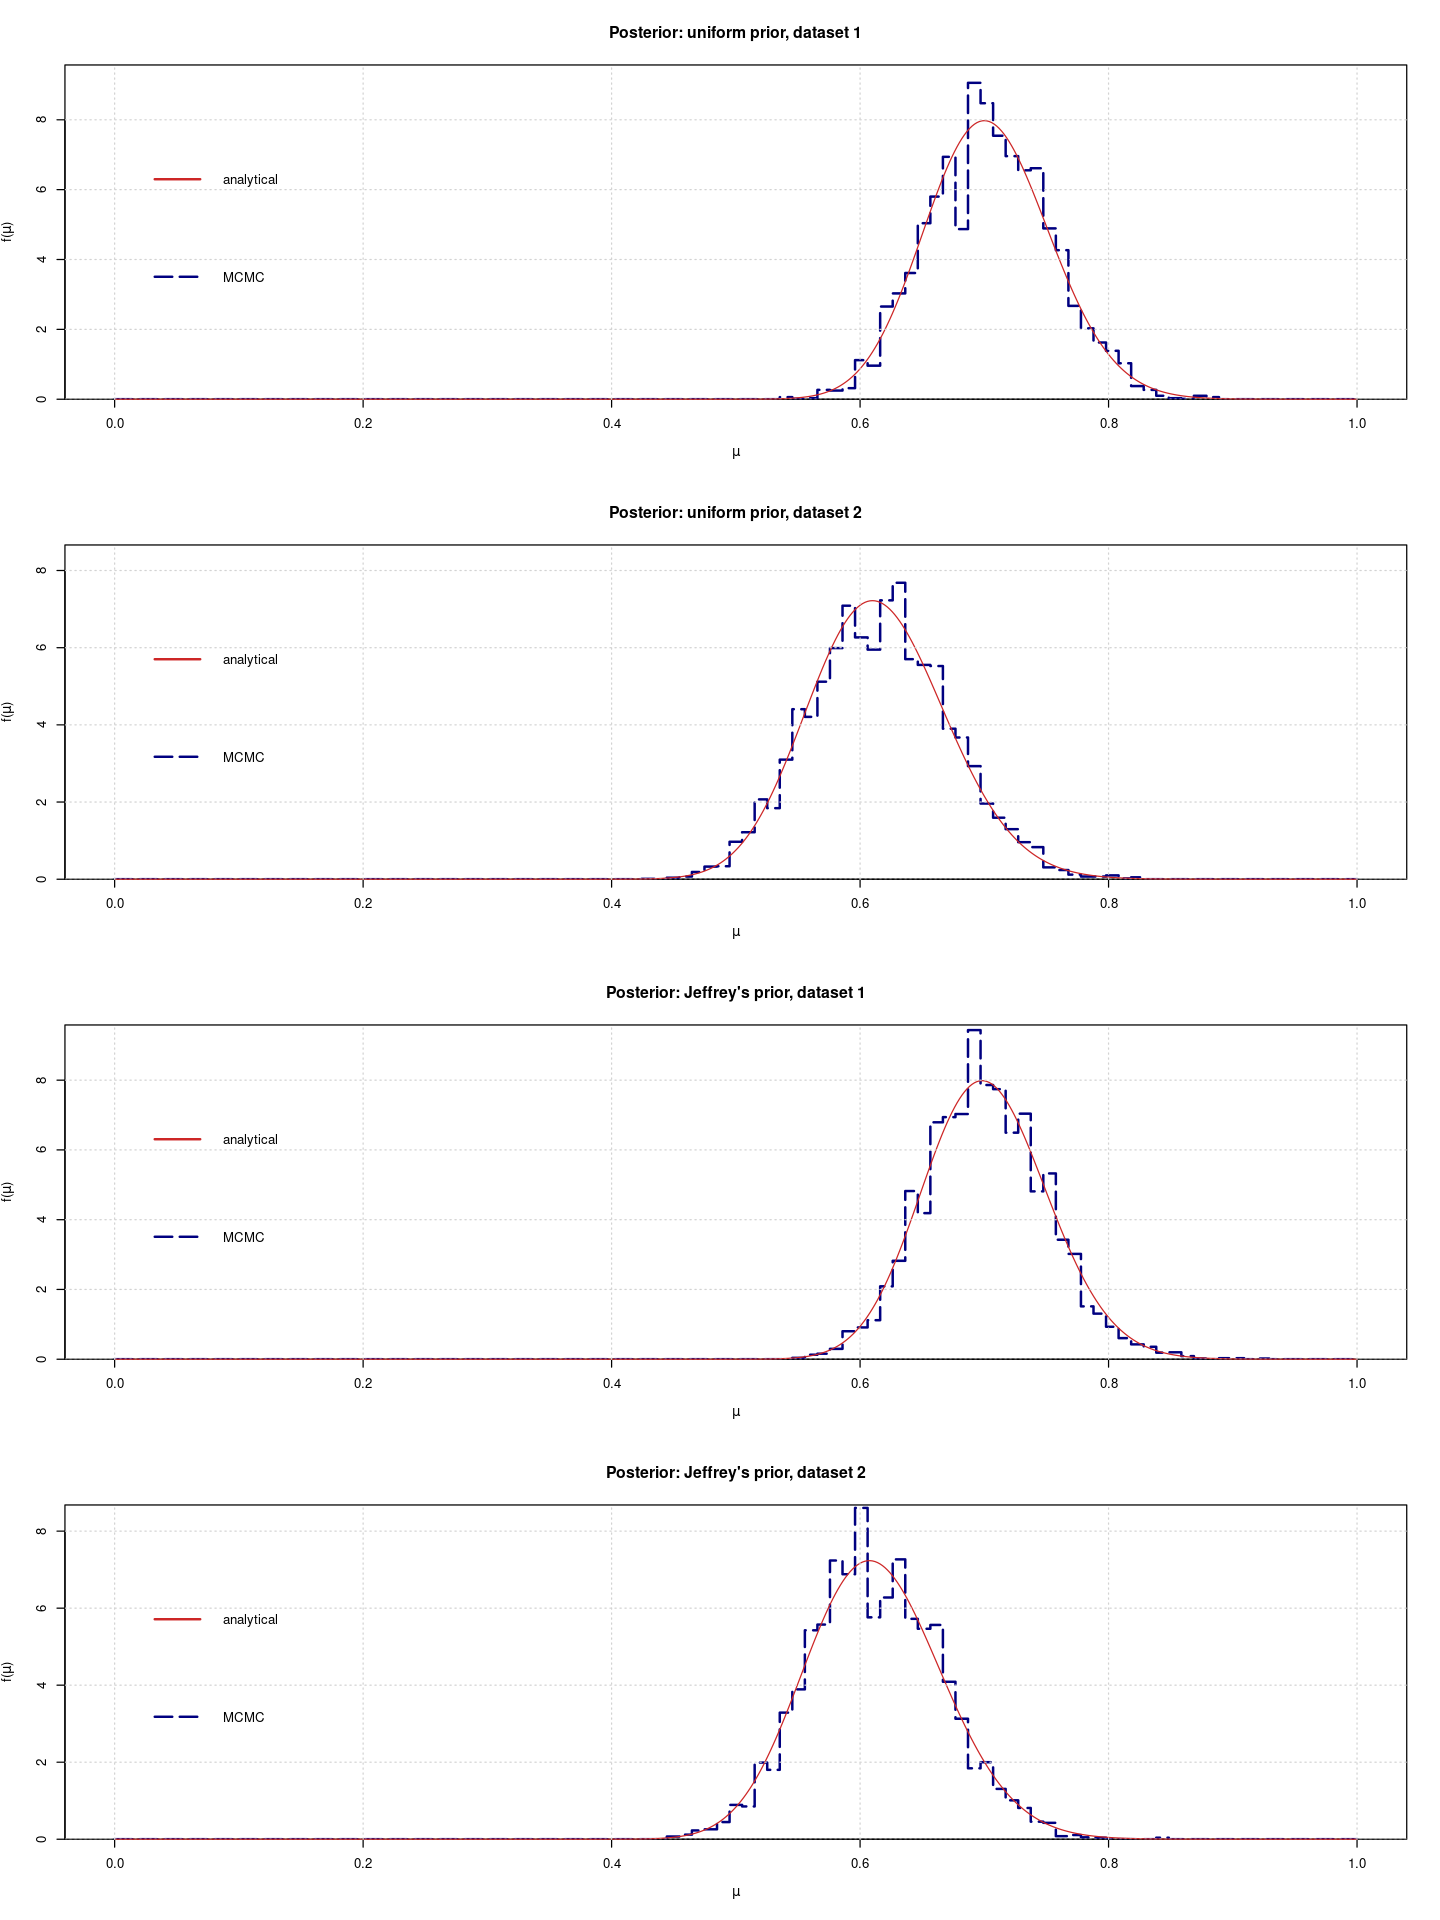

In [12]:
options(repr.plot.width=12, repr.plot.height=16)
par(mfrow=c(4,1))#, mgp=c(2,.5,.5), mar=c(3,3,1,1), oma=0.7*c(1,1,1,1))

th_vs_MC(postu1,metropolis.1dim(func= postu1),'Posterior: uniform prior, dataset 1')
th_vs_MC(postu2,metropolis.1dim(func= postu2),'Posterior: uniform prior, dataset 2')
th_vs_MC(postj1,metropolis.1dim(func= postj1),'Posterior: Jeffrey\'s prior, dataset 1')
th_vs_MC(postj2,metropolis.1dim(func= postj2),'Posterior: Jeffrey\'s prior, dataset 2')

Now I want to briefly examinate autocorrelation. I set a sample size of $10^4$ points, which should be enough so I don't need much auto-correlation in order to get a good result. As we can see, $\sigma = 0.3$ is very safe and does not provide evident autocorrelation.

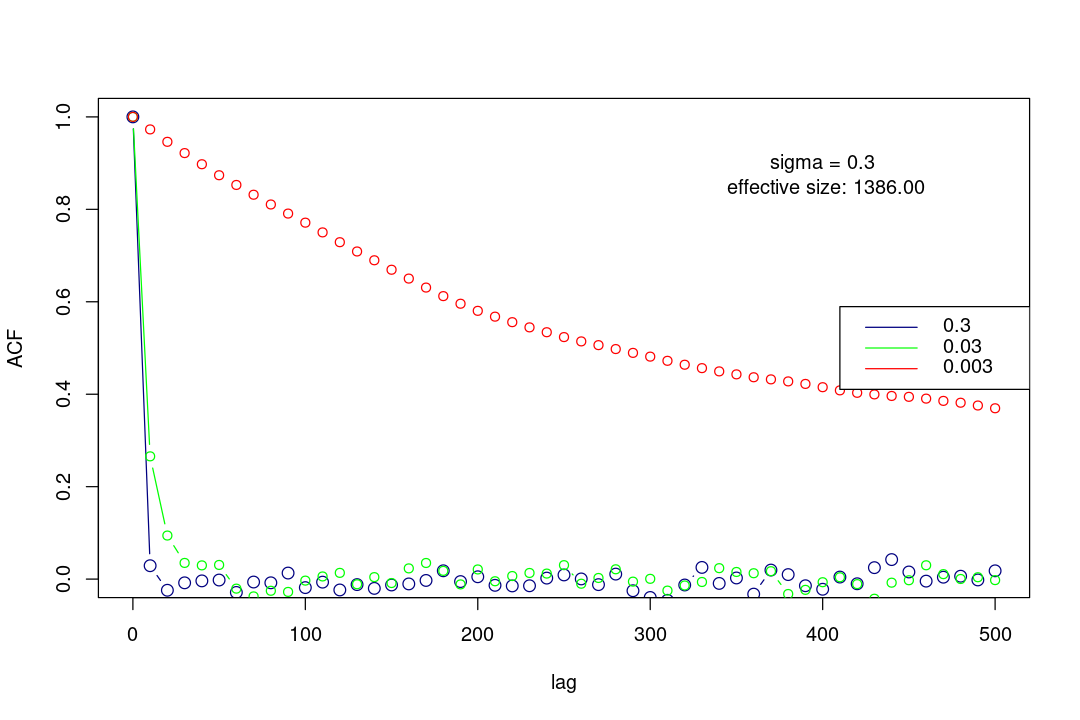

In [13]:
c.chain <- as.mcmc(chain[,2])

my.lags = seq(0,500,10)
y1 <- autocorr(c.chain, lags=my.lags)

options(repr.plot.width=9, repr.plot.height=6)

plot(my.lags , y1, ylim=c(0,1),
 type='b',col='navy',
xlab='lag', ylab='ACF', cex=1.3)
text(400,0.9, paste('sigma =',mc_sigma))
text(400,0.85,
sprintf (" effective size: %.2f",
effectiveSize(c.chain)))

chain1b <- metropolis.1dim(func= postu1, sigma=0.03)
c.chain1b <- as.mcmc(chain1b[,2])
y1b <- autocorr(c.chain1b, lags=my.lags)
lines(my.lags , y1b, ylim=c(0,1),
 type='b',col='green')

chain1c <- metropolis.1dim(func= postu1,sigma=0.003)
c.chain1c <- as.mcmc(chain1c[,2])
y1c <- autocorr(c.chain1c, lags=my.lags)
lines(my.lags , y1c, ylim=c(0,1),
 type='b',col='red')

legend('right',legend=c(mc_sigma,0.03,0.003),
       col=c('navy','green','red'),lt=1)


# Exercise 3

During a study on water quality of streams, a high level of bacter X was defined as a level greater than 100 per 100 ml of stream water. $n = 116$ samples were taken from streams having a high environmental impact on pandas. Out of these, $y = 11$ had a high bacter X level. Indicating with $p$ the probability that a sample of water taken from the stream has a high bacter X level:

#### a) Find the frequentist estimator for p
In the frequentist approach, the event 'finding a high bacter level' follows a binomial distribution with the best estimate for $p$ is $p = y/n$.

In [14]:
ya <- 11
na <- 116
N3 <- 501
freq.p <- function(y,n){
    f.p <- y/n
    cat('Frequentist estimator: p = y/n =',f.p,'\n')
    return (f.p)
}
f.p <- freq.p(ya,na)

Frequentist estimator: p = y/n = 0.09482759 


#### b) using a ``Beta(1, 10)`` prior for $p$, calculate the posterior distribution $P(p∣y)$

#### c) find the bayesian estimator for p, the posterior mean and variance, and a 95% credible interval

#### d) test the hypotesis $H_0: p = 0.1$ versus $H_1:p\neq 0.1$ at 5% level of significance with both the frequentist and bayesian approach

In [15]:
infereBer <- function(y,n,beta.par,overlay=FALSE,atitle,ucol='forestgreen',pH0) {
    N1 <- 501
    #counts1 <- length(series1)
#    p1 <- seq(0,counts1,by=1)
    p <- seq(0,1,length.out=N1)

    a <- y + beta.par[1] #alpha.post; beta.par=c(alpha,beta)
    b <- n - y + beta.par[2] #beta.post

    post.b <- function(p) {dbeta(p,shape1=a,shape2=b)} #*N1/sum(dbeta(p,a,b))    
    
    mean <- a/(a+b)
    variance <- a*b/((a+b+1)*(a+b)^2)
    std <- sqrt(variance)
    median <- qbeta(0.5,a,b)

    cat('\n',atitle,'\n')
    cat('I found a posterior with alpha =',a,'and beta =',b,'\n')
    cat('I found a posterior with best estimate of p = mean =',round(mean,3),'\nvariance =',
        round(variance,5),'and std. dev. =',round(std,3),'\n')

    #plots
    q = 0.025
    left = qbeta(q,a,b)
    right = qbeta(1-q,a,b)
    cat('Credibility interval: left bound =',left,'right bound =',right,'\n')
        #main plot
    if (overlay==FALSE){
        myplot(p,post.b(p),fillit = FALSE,title = atitle,mycol=ucol,
               xrange=c(0,mean+5*std),xlab = 'p')
    } else{
        mylines(p,post.b(p),mycol=ucol,
                xlab = expression(mu))
    }
        #secondary plots
    mypoly(post.b,qleft=left,qright=right,mycol=ucol,N1=501)
    mytext(c(left,right),posy=1.3,mycol=ucol,ltype=3)
    mytext(mean,posy=3.3,mycol=ucol,ltype=2)
    mytext(pH0,posy=5.3,mycol='navy',ltype=4)

    
    legend('topright',legend=c('Posterior','Mean',
        '0.95 CI delimiters','p(H0)'),
       col=c(ucol,ucol,ucol,'navy'),lt=c(1,2,3,4))
    
    HTresult <- ifelse(pH0<left,'rejected',ifelse(pH0<right,'accepted','rejected'))
    cat('The null hypothesis H0: p =',pH0,'is',HTresult,'from a 2-side Hypothesis Test with a 0.05 level of significance')
    
    return(c(a,b))
}

In [16]:
infereBerF <- function(y,n,atitle,ucol='forestgreen',pH0,bounds) {
                 
    x <- seq(bounds[1],bounds[2],by=1)                        
    p.f <- y/n
    
    post.f <- function(p) {dbinom(y,n,p)*N1/sum(dbinom(y,n,p))}

    #plots                 
    options(repr.plot.width=9, repr.plot.height=6)
    q <- 0.025
    yf <- dbinom(x,n,pH0)
    left <- qbinom(q,n,pH0)
    right <- qbinom(1-q,n,pH0)
    
    plot(x-0.5,yf,type='s',col=ucol,main=atitle,xlab='y',ylab='pdf')
        mytext(c(left,right),posy=.02,mycol=ucol,ltype=3)
        mytext(y,posy=.05,mycol='navy',lwd=2,ltype=2)

    grid()    
    legend('topright',legend=c('Posterior',
        '0.95 CI delimiters','y'),
       col=c(ucol,ucol,'navy'),lt=c(1,3,2))

    cat('Best estimate of p = ',p.f,'\n')
    cat('Confidence interval: left bound =',left,'right bound =',right,'\n')
    HTresult <- ifelse(y<left,'rejected',ifelse(y<right,'accepted','rejected'))
    cat('The null hypothesis H0: p =',pH0,'is',HTresult,'from a 2-side Hypothesis Test with a 0.05 level of significance')
    
}


 Bayesian est. with Beta prior, y=11,n=116 
I found a posterior with alpha = 12 and beta = 115 
I found a posterior with best estimate of p = mean = 0.094 
variance = 0.00067 and std. dev. = 0.026 
Credibility interval: left bound = 0.05018522 right bound = 0.1508379 
The null hypothesis H0: p = 0.1 is accepted from a 2-side Hypothesis Test with a 0.05 level of significance

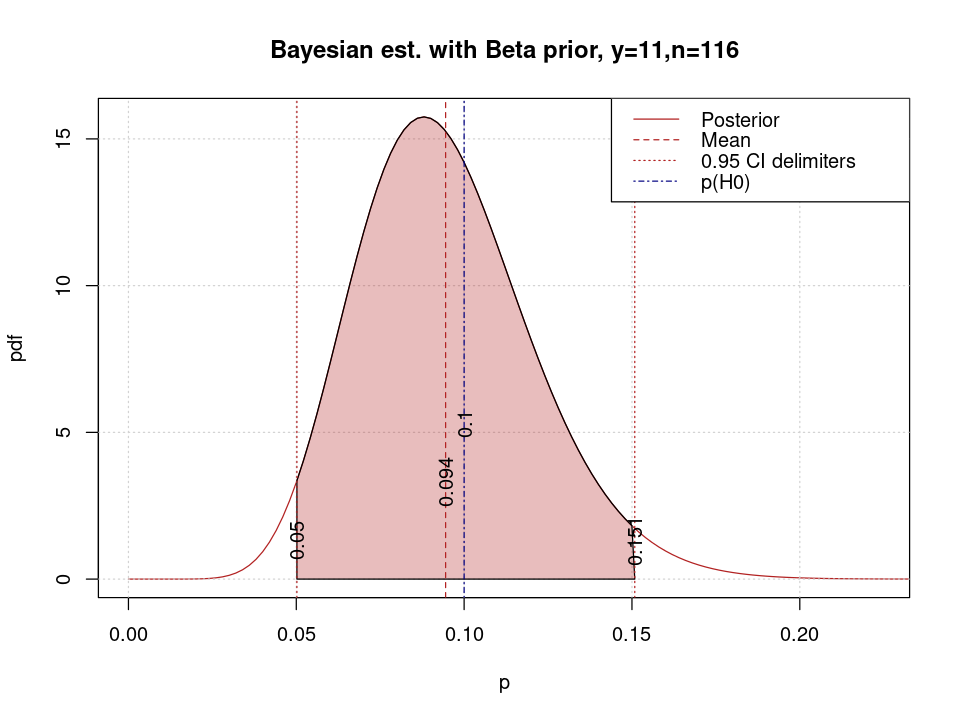

In [17]:
alpha <- 1; beta <- 10

b.titles = c('Bayesian est. with Beta prior, y=11,n=116','Bayesian est. with Beta prior, y=9,n=165','Bayesian est. with 3.b posterior as prior, y=9,n=165')

b.cols = c('firebrick','purple','magenta')

postbay1 <- infereBer(ya,na,beta.par=c(alpha,beta),atitle=b.titles[1],ucol=b.cols[1],pH0=0.1)

In the frequentist approach:

Best estimate of p =  0.09482759 
Confidence interval: left bound = 6 right bound = 18 
The null hypothesis H0: p = 0.1 is accepted from a 2-side Hypothesis Test with a 0.05 level of significance

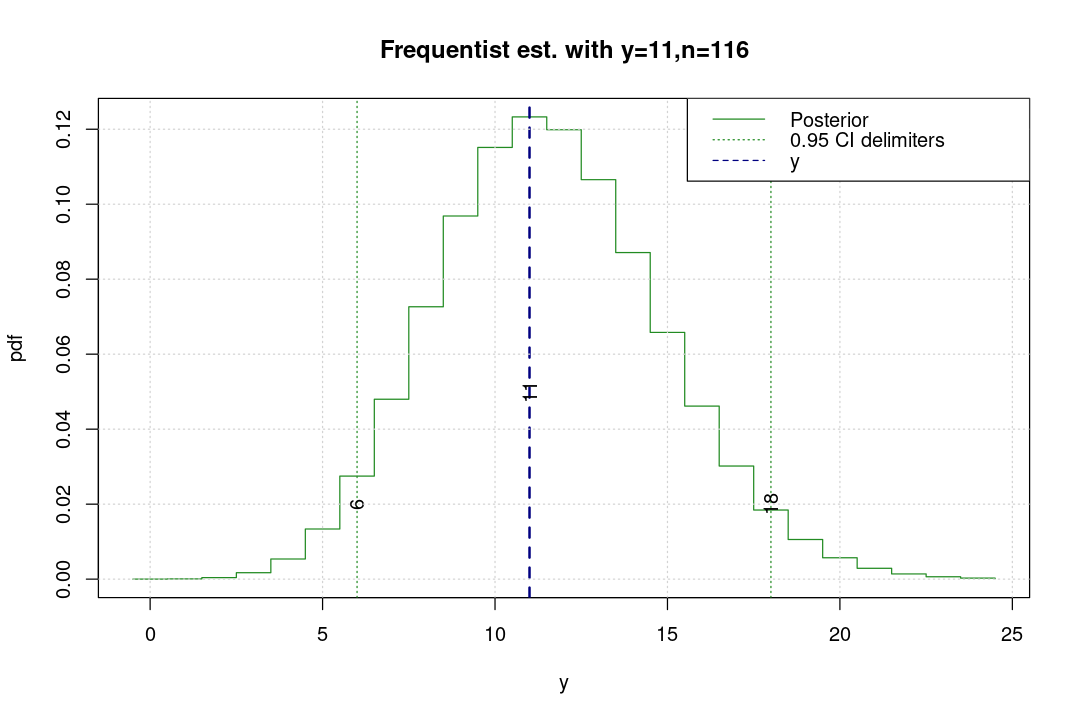

In [18]:
f.titles = c('Frequentist est. with y=11,n=116','Frequentist est. with y=9,n=165')

infereBerF(y=ya,n=na,atitle=f.titles[1],ucol='forestgreen',pH0=0.1,bounds=c(0,25)) 

A new measurement, performed one month later on $n = 165$ water samples, gives $y = 9$ high bacter
X level.

#### e) find the frequentist estimator for $p$

Same as 3.a.


#### f) find a bayesian estimator for p, assuming both a ``Beta(1, 10)`` prior for $p$, and assuming the posterior probability of the older measurement as the prior for the new one.

#### g) find the bayesian estimator for $p$, the posterior mean and variance, and a $95\%$ credible interval

#### h) test the hypotesis $H_0: p = 0.1$ versus $H_1:p\neq 0.1$ at 5% level of significance with both the frequentist and bayesian approach

In [19]:
yb <- 9
nb <- 165
N3 <- 501
freq.p <- function(y,n){
    f.p <- y/n
    cat('Frequentist estimator: p = y/n =',f.p,'\n')
    return (f.p)
}
f.p <- freq.p(yb,nb)

Frequentist estimator: p = y/n = 0.05454545 



 Bayesian est. with Beta prior, y=9,n=165 
I found a posterior with alpha = 10 and beta = 166 
I found a posterior with best estimate of p = mean = 0.057 
variance = 3e-04 and std. dev. = 0.017 
Credibility interval: left bound = 0.02773918 right bound = 0.09538012 
The null hypothesis H0: p = 0.1 is rejected from a 2-side Hypothesis Test with a 0.05 level of significance

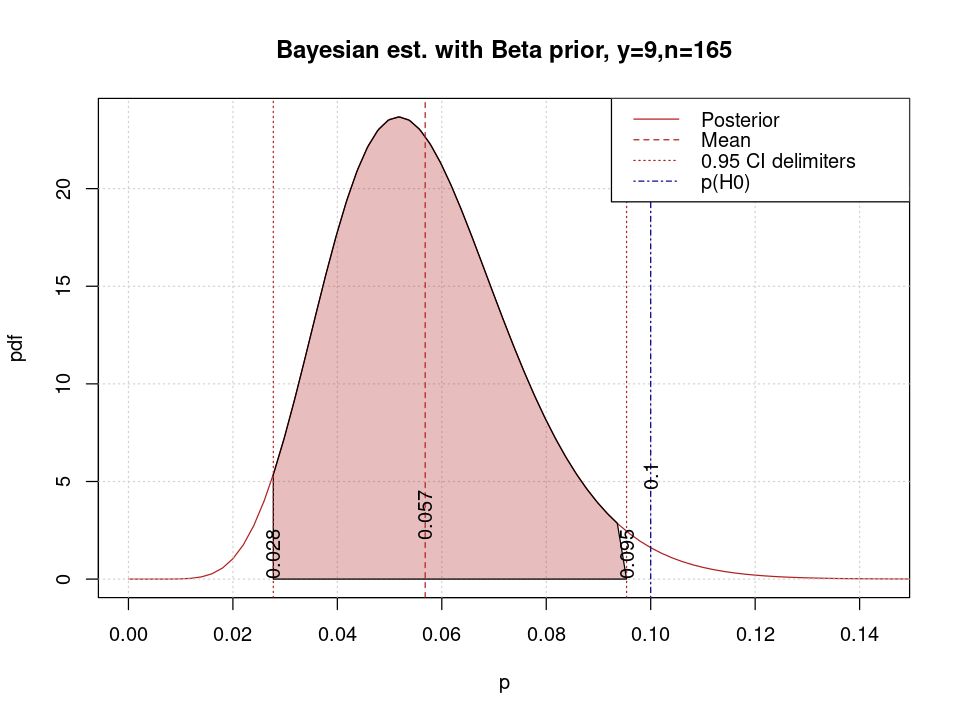

In [20]:
alpha <- 1; beta <- 10
postbay2 <- infereBer(yb,nb,beta.par=c(alpha,beta),atitle=b.titles[2],ucol=b.cols[1],pH0=0.1)


 Bayesian est. with 3.b posterior as prior, y=9,n=165 
I found a posterior with alpha = 21 and beta = 271 
I found a posterior with best estimate of p = mean = 0.072 
variance = 0.00023 and std. dev. = 0.015 
Credibility interval: left bound = 0.04522356 right bound = 0.1041519 
The null hypothesis H0: p = 0.1 is accepted from a 2-side Hypothesis Test with a 0.05 level of significance

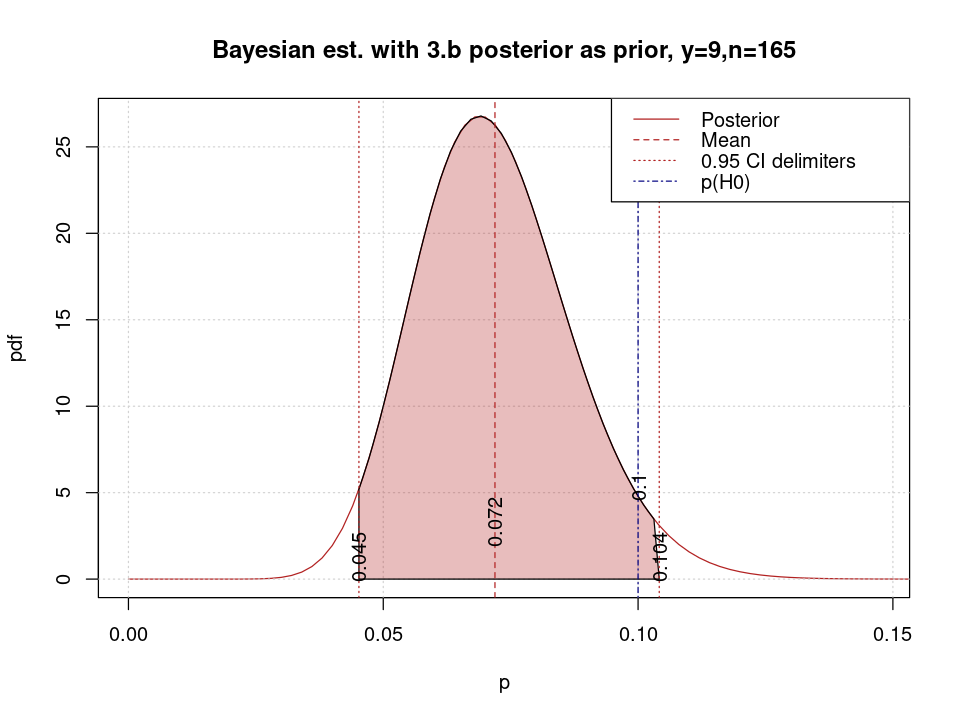

In [21]:
alpha <- postbay1[1]; beta <- postbay1[2]
postbay3 <- infereBer(yb,nb,beta.par=c(alpha,beta),atitle=b.titles[3],ucol=b.cols[1],pH0=0.1)

Best estimate of p =  0.05454545 
Confidence interval: left bound = 9 right bound = 24 
The null hypothesis H0: p = 0.1 is accepted from a 2-side Hypothesis Test with a 0.05 level of significance

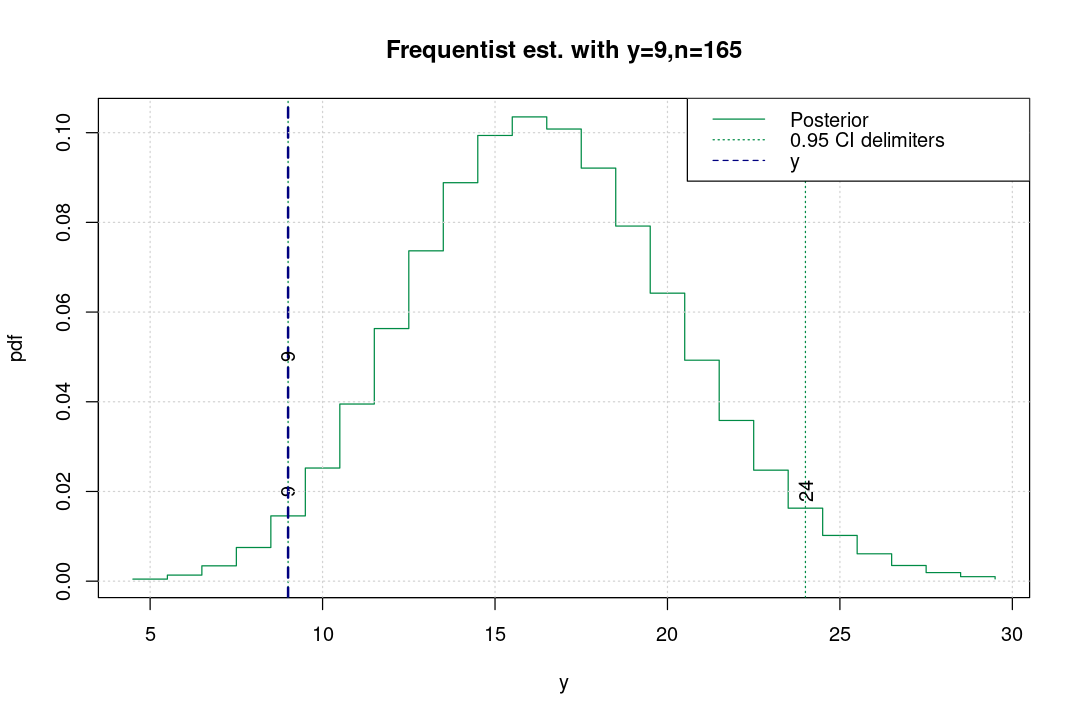

In [22]:
infereBerF(y=yb,n=nb,atitle=f.titles[2],ucol='springgreen4',pH0=0.1,bounds=c(5,30)) 

Bonus: let's try to combine the two experiments to see if also the frequentist approach can pass the HT for $H_0$.

Best estimate of p =  0.07117438 
Confidence interval: left bound = 19 right bound = 38 
The null hypothesis H0: p = 0.1 is accepted from a 2-side Hypothesis Test with a 0.05 level of significance

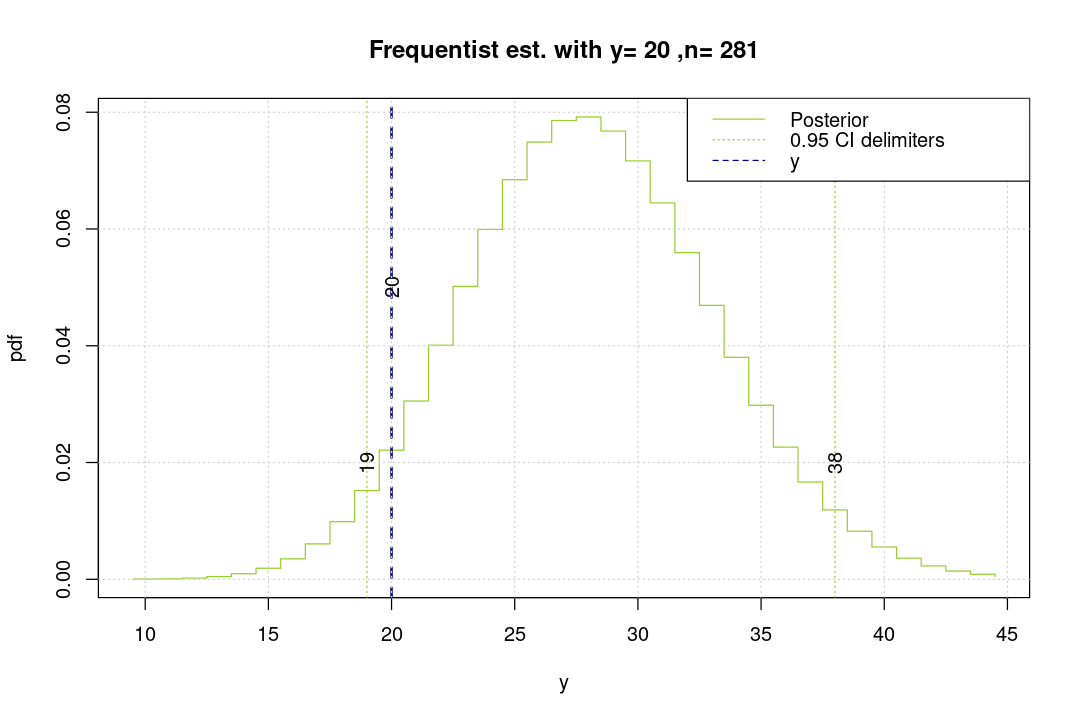

In [23]:
infereBerF(y=ya+yb,n=na+nb,atitle=paste('Frequentist est. with y=',ya+yb,',n=',na+nb)
           ,ucol='olivedrab3',pH0=0.1,bounds=c(10,45)) 

Some takeaways: 
- Both approaches work better if we keep track of previous measurements. In the bayesian approach, the HT failed considering the second experiment alone, but succeeded when taking into account the results from 3.b.
- Similarly, in the frequentist approach, combining the datasets (not the posteriors) passed the HT. The two approaches led to a similar final estimate of $p$ as $p_{Bayes} = 0.072$ and $p_{Freq} = 0.071$ 

# Ex 4
Analyze the data of Exercise 3 and solve points (b) and (c) using a MCMC with JAGS.

JAGS script:

``
model {
#data likelihood
for (i in 1: length(X)) {
X[i] ~ dbern(p);
}
#a uniform prior for p
p ~ dbeta(1, 10);
#Predicted data, given p
y ~ dbin(p, n);
}
``

First, I simulate a $n$ sequence of extractions bearing exactly $y$ positive results:

In [24]:
y4 <- 11
n4 <- 116
set.seed(2097126)
dots <- sample(1:n4,size=y4,replace=TRUE)
measures <- rep(0,n4)
measures[measures=dots] = 1

Then, I create a list from my data.

In [25]:
data <- NULL
data$X <- measures
data$n <- length(measures) 

Now I define the model and call ``jags``.

In [26]:
model <- "pred.bug"
jm <- jags.model(model,data)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 116
   Unobserved stochastic nodes: 2
   Total graph size: 121

Initializing model



In [27]:
update(jm,1000)

In [28]:
chain <- coda.samples(jm, c('p','y'),n.iter=10000)

In [29]:
chain.df <- as.data.frame ( as.mcmc( chain ) )
summary(chain.df)

       p                 y        
 Min.   :0.02393   Min.   : 0.00  
 1st Qu.:0.07619   1st Qu.: 8.00  
 Median :0.09275   Median :11.00  
 Mean   :0.09491   Mean   :11.04  
 3rd Qu.:0.11128   3rd Qu.:14.00  
 Max.   :0.24161   Max.   :30.00  

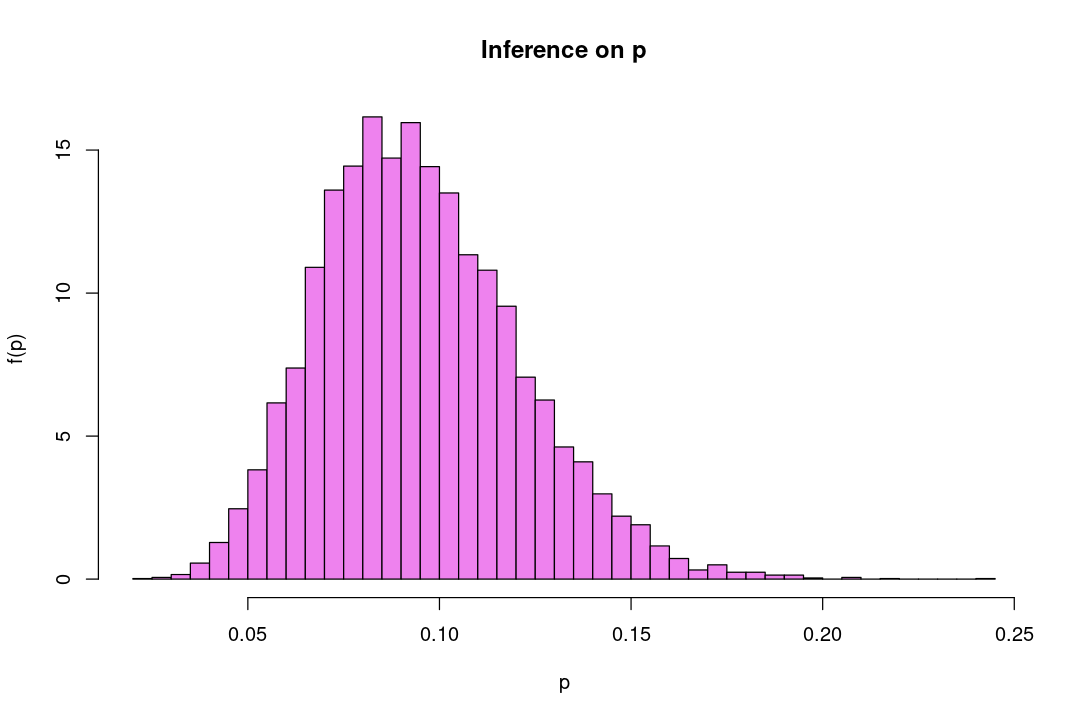

In [30]:
mchist <- hist( chain.df$p, nc=50, prob=TRUE , col='violet',
xlab='p', ylab='f(p)', main='Inference on p')

In [31]:
ql <- 0.025*sum(mchist$counts)
qr <- (1-0.025)*sum(mchist$counts)
lbound <- 0
rbound <- 0
cl <- 1; cr <- 1
while (lbound < ql) {
    lbound <- lbound + mchist$counts[cl]
    cl <- cl + 1
}
while (rbound < qr) {
    rbound <- rbound + mchist$counts[cr]
    cr <- cr + 1
}
ql <- mchist$breaks[cl]
qr <- mchist$breaks[cr]
ql

[1] 0.055

Theoretical mean, p= 0.09448819 JAGS mean= 0.09463

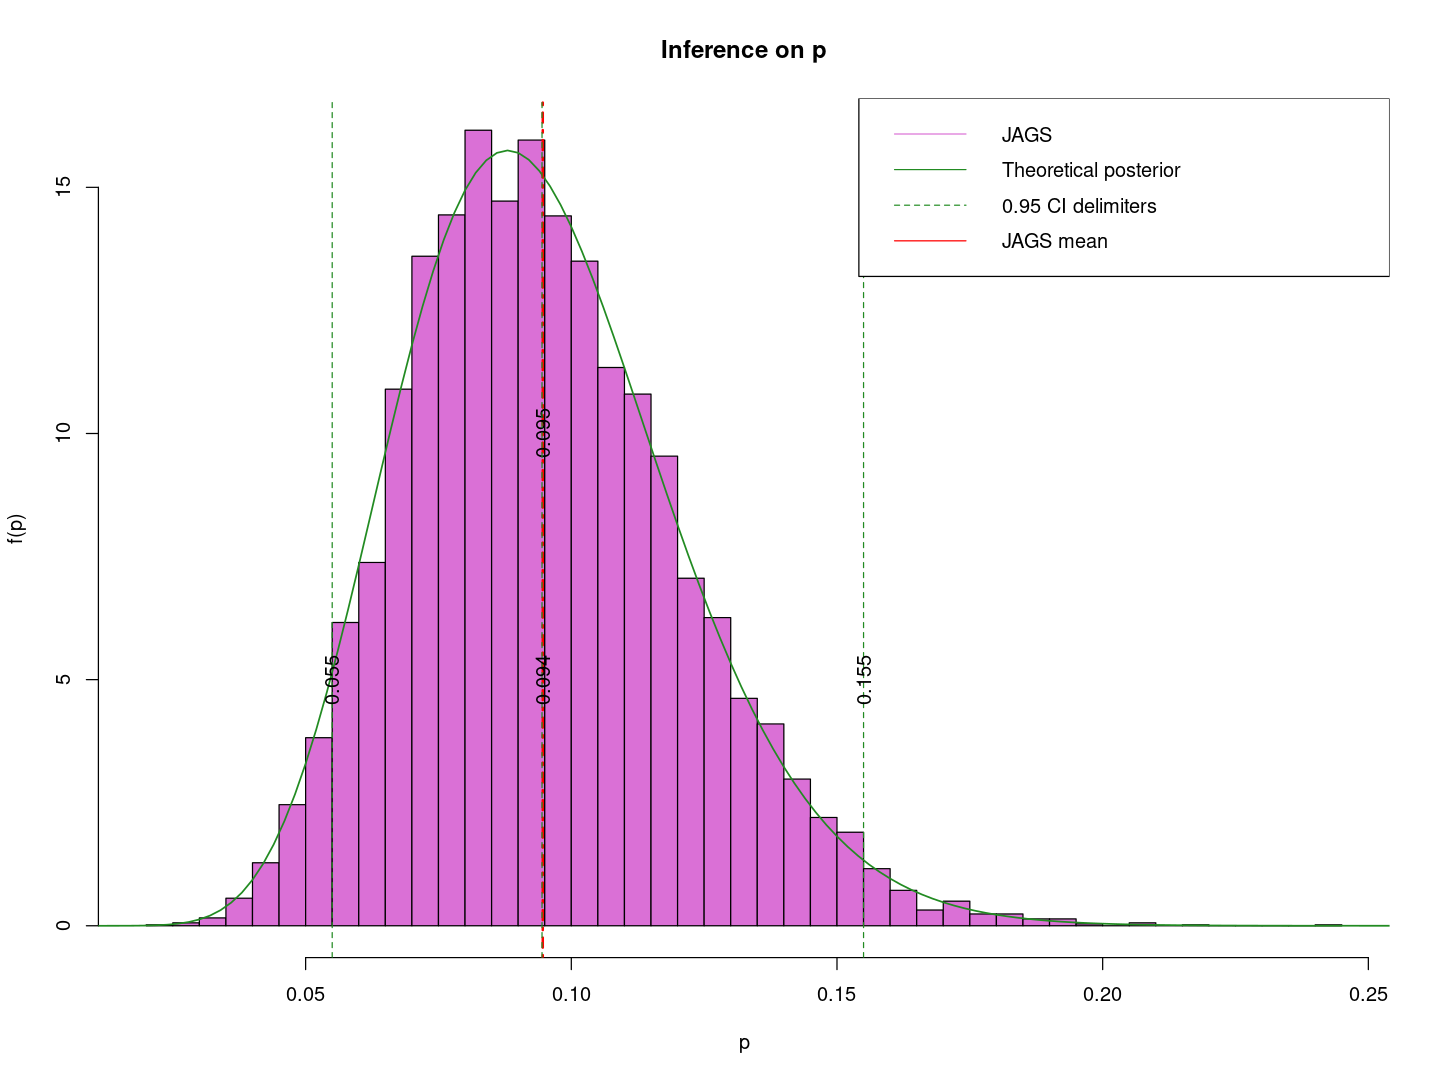

In [32]:
options(repr.plot.width=12, repr.plot.height=9)


hist( chain.df$p, nc=50, prob=TRUE , col='orchid',
xlab='p', ylab='f(p)', main='Inference on p')
x5 <- seq(0,1,length.out=501)
a4 <- 1+y4; b4 <- n4-y4+10
lines(x5,dbeta(x5,a4,b4),col='forestgreen',lwd=1.4)
mytext(c(ql,qr),mycol='forestgreen')
mc.mean <- 0.09463
mytext(mc.mean,posy=10,mycol='red',lwd=2,lty=4)
mytext(a4/(a4+b4),mycol='forestgreen',lwd=1)

legend('topright',legend=c('JAGS','Theoretical posterior',
        '0.95 CI delimiters','JAGS mean'),
       col=c('orchid','forestgreen','forestgreen','red'),lt=c(1,1,2))
#infereBer(y4,n4,beta.par=c(1,10),overlay=TRUE,atitle='Inference on p',ucol='forestgreen',pH0) 

cat('Theoretical mean, p=',a4/(a4+b4),'JAGS mean=',mc.mean)